<br>
<div style="text-align:center"> <h1> Processing and Analysis - Podesta (John podesta - US Politician) Emails </h1> </div>
<br>
<br>
<div style="text-align:align">
Processing and analysing  email exports hosted by wikileaks retrieved from US politician John Podesta's gmail account, reportedly by russian hackers. The hacking seems to have been motivated to favor Trumps election as the president of the US. 
<br><br>
John Podesta was the Hillary's campaign manager and the chief of staff for president Bill CLinton between 1998 and 2001
</div>

**Email Dataset Download:**<br>
https://file.wikileaks.org/file/podesta-emails/


**Wikileaks Description:**<br>
https://wikileaks.org/podesta-emails/?q=delonge%7C%22tom+delany%22%7C%22blink182%22%7C%22blink+182%22%7CUFO&mfrom=&mto=&title=&notitle=&date_from=&date_to=&nofrom=&noto=&count=50&sort=6



**Additional Useful Links:**<br>
https://docs.microsoft.com/en-us/office365/securitycompliance/anti-spam-message-headers

https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24



**Things to Clean up:**<br>
* Try to make the code faster
* Replace loops and unwanted code
* cleanup variable names


**Next Steps:**<br>
* Create network graphs with contacts
* Identify topics


In [121]:
# importing all packages that may be required

import os
import re
# import gc
import csv
# import html
import copy
import time
import string
import mailbox
import warnings
# import chardet
import pandas as pd
# import unicodedata
# import multiprocessing
from nltk import pos_tag as pt
from nltk.corpus import stopwords
# from dask import dataframe as dd
from bs4 import BeautifulSoup as bs
# from email.utils import parsedate
from nltk.corpus import wordnet as wn
# from dask.multiprocessing import get
# from dask.diagnostics import ProgressBar
from tqdm._tqdm_notebook import tqdm_notebook
from nltk.stem import WordNetLemmatizer as wnl

warnings.filterwarnings('ignore')

In [122]:
cwd = os.getcwd()

In [123]:
# importing mailbox
mail_container = mailbox.mbox(cwd+'/raw_data/podesta-emails.mbox-2016-11-06')

In [124]:
# making working copy of the mailbox
mail_cp = copy.copy(mail_container)

In [125]:
# cleans the input string , removes email addresses, links and unwanted characters
def clean(msg_content):
    if msg_content!=None:
        msg_clean = ''.join([ch for ch in str(msg_content) if ord(ch)<= 128])
        msg_clean = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', msg_clean)
        msg_clean = re.sub(r'\S+@\S+','', msg_clean)
        for r in ['\\n', '\n', '\r', '\t', '\\t', 'None', 'none']: msg_clean = msg_clean.replace(r, ' ')
        msg_clean = re.sub(r' +', ' ', re.sub("[/\\\:?\"]", '', msg_clean))
        msg_clean = ' '.join(w.strip() for w in msg_clean.lstrip().split(" ") if w!=" ")
    return msg_clean

In [126]:
# extracts tags from mails and writes to csv by row - unused
def extract_body_tocsv(mail_cp):
    try:
        with open('podesta_mailbox.csv', 'w', encoding='utf-8', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['date', 'from', 'to', 'cc', 'subject', 'originator_org', 'spam_header', 'msg_body'])
            for mail in mail_cp.itervalues():
                if mail.is_multipart():
                    for part in mail.walk():
                        if part.get_content_type()=='text/plain':
                            try:
                                msg_content = part.get_payload(decode=True).decode(part.get_content_charset())
                            except:
                                msg_content = part.get_payload(decode=True)
                        elif part.get_content_type()=='text/html':
                            msg_content = bs(mail_cp[3].get_payload(decode=True)).get_text()
                            
                else:
                    if mail.get_content_type()=='text/plain':
                        try:
                            msg_content = mail.get_payload(decode=True).decode(mail.get_content_charset())
                        except:
                            msg_content = mail.get_payload(decode=True)
                    elif part.get_content_type()=='text/html':
                        msg_content = bs(mail_cp[3].get_payload(decode=True)).get_text()
                writer.writerow([mail['Date'], mail['From'], mail['To'], mail['Cc'],
                                 mail['Subject'], mail['X-OriginatorOrg'],
                                 mail['SpamDiagnosticMetadata'],clean(msg_content.lower())]) 
    except:
        pass

In [127]:
# llist comprehension code
# msg_content = [mail.get_payload(decode=True) if mail.get_content_type()=='text/plain' else None][0]
# try:
#     msg_content = msg_content.decode(part.get_content_charset())
# except:
#     pass


Extract function extracts email tags and body from specific mails within the mailbox,
* extracts emails from the mailbox
* gets the 'date', 'from', 'to', 'cc', 'subject', 'originator_org', 'spam_header' tags
* Text and Html content is extracted from the mail body, html content is parsed using bs4 and plain text is decoded is non null string
<br><br>
Clean Function cleans extracted body,
* removes links, email addresses and other unwanted characters
* uses regex and replace functions


In [128]:
#writes to dataframe
def extract_body_topandas(mail_cp):
    df = pd.DataFrame(columns=['date', 'from', 'to', 'cc', 'subject', 'originator_org', 'spam_header', 'msg_body'])
    for mail in mail_cp.itervalues():
        if mail.is_multipart():
            for part in mail.walk():
                if part.get_content_type()=='text/plain':
                    try:
                        msg_content = part.get_payload(decode=True).decode(part.get_content_charset())
                    except:
                        msg_content = part.get_payload(decode=True)
                elif part.get_content_type()=='text/html':
                    msg_content = bs(mail_cp[3].get_payload(decode=True)).get_text()

        else:
            if mail.get_content_type()=='text/plain':
                try:
                    msg_content = mail.get_payload(decode=True).decode(mail.get_content_charset())
                except:
                    msg_content = mail.get_payload(decode=True)
            elif part.get_content_type()=='text/html':
                msg_content = bs(mail_cp[3].get_payload(decode=True)).get_text()
        d = pd.DataFrame({'date': mail['Date'], 'from': mail['From'],
                          'to': mail['To'], 'cc': mail['Cc'],'subject': mail['Subject'],
                          'originator_org': mail['X-OriginatorOrg'],'spam_header': mail['SpamDiagnosticMetadata'],
                          'msg_body': clean(msg_content.lower())}, index=[0])
        df = pd.concat([df, d])
    return df

In [129]:
# running function and display time
%time podesta_df = extract_body_topandas(mail_cp)
# 25 mins

CPU times: user 25min 14s, sys: 1min 18s, total: 26min 33s
Wall time: 27min 36s


In [130]:
#checking is number of emails matches with extracted, it may not match in some cases depending on email content
len(mail_cp) == len(podesta_df)
del mail_cp
del mail_container

In [131]:
podesta_df.head(2)

,cc,date,from,msg_body,originator_org,spam_header,subject,to
0,None,"Fri, 3 Apr 2015 14:06:30 +0000",Tina Flournoy <Tina@presidentclinton.com>,sc was the first thing he mentioned. told him to talk to you about greece,None,None,just talked to him,John Podesta <john.podesta@gmail.com>
0,None,"Mon, 22 Feb 2016 23:00:30 +0000",Ira Shapiro <ira@shapiroglobal.com>,"dear john, it was a pleasure serving you on your recent flight from atlanta (atl) to washington (i...",shapiroglobal.com,NSPM,today's fundraiser,John Podesta <john.podesta@gmail.com>


The extracted text will be cleaned with the below functions;

* mail_extract - extracts email address and removes unwanted characters
* name_extract - extracts names from emails

In [132]:
def mail_extract(x):
    x = re.search(r'\S+@\S+', str(x).lower())
    if x:
        return x.group().replace('>','').replace('<','').lower()

def name_extract(y):
    y = str(y).lower()
    erem = re.sub(r'\S+@\S+', '', y)
    if  erem==None or erem==" " or erem=="":
        return re.search(r'.*?(?=@)', y).group().replace('>', '').replace('<', '').replace('.', ' ')
    else:
        return [clean(erem) if clean(erem)!='' else (re.sub(r'<(.*?)>', '', y).replace('\n', ''))][0]

In [133]:
podesta_df['to_email'] = podesta_df['to'].apply(lambda x: mail_extract(x))
podesta_df['from_email'] = podesta_df['from'].apply(lambda x: mail_extract(x))

podesta_df['to_name'] = podesta_df['to'].apply(lambda x: name_extract(x))
podesta_df['from_name'] = podesta_df['from'].apply(lambda x: name_extract(x))


Extracting dates from the column with mixed dateformats and parsing the dates

In [134]:
start = time.time()
podesta_df['conv_date'] = ''
for x in range(len(podesta_df['date'])):
    try:
        podesta_df['conv_date'].iloc[x] = re.search(r'\d{1,2}(.*?)\d{2,4}(.*?)[0-9]{2}:[0-9]{2}',podesta_df['date'].iloc[x]).group()
    except:
        podesta_df['conv_date'].iloc[x] = None
podesta_df['conv_date'] = pd.to_datetime(podesta_df['conv_date'])
del x
print((time.time()-start)/60)
del start

2.801089866956075


In [135]:
podesta_df.head(2)

,cc,date,from,msg_body,originator_org,spam_header,subject,to,to_email,from_email,to_name,from_name,conv_date
0,None,"Fri, 3 Apr 2015 14:06:30 +0000",Tina Flournoy <Tina@presidentclinton.com>,sc was the first thing he mentioned. told him to talk to you about greece,None,None,just talked to him,John Podesta <john.podesta@gmail.com>,john.podesta@gmail.com,tina@presidentclinton.com,john podesta,tina flournoy,2015-04-03 14:06:00
0,None,"Mon, 22 Feb 2016 23:00:30 +0000",Ira Shapiro <ira@shapiroglobal.com>,"dear john, it was a pleasure serving you on your recent flight from atlanta (atl) to washington (i...",shapiroglobal.com,NSPM,today's fundraiser,John Podesta <john.podesta@gmail.com>,john.podesta@gmail.com,ira@shapiroglobal.com,john podesta,ira shapiro,2016-02-22 23:00:00


The extracted and cleaned text body is processed through the below stages,
* Tokenizing by whitespaces
* Removing stop words
* Tagging Parts of Speech
* Lemmatizing words (Stemmer is faster but less accurate)
* Removing punctuations
* Removing numbers
* Converting all text to lower case

Information maybe considered in the later stages of analysis

In [136]:
def get_wordnet_pos(word):
    if word.startswith('J'):
        return wn.ADJ
    elif word.startswith('V'):
        return wn.VERB
    elif word.startswith('N'):
        return wn.NOUN
    elif word.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def txt_processing(msg_content):
    l=[]
    stop = msg_content.split()
    stop_words = set(stopwords.words('english'))
    filtered = [w for w in stop if w not in stop_words]
    ptag = pt(filtered)
    for word in ptag:
        lem = wnl().lemmatize(word[0], get_wordnet_pos(word[1]))
        if lem!=None or lem!='' or lem!=' ':
            l.append(str(lem.lower()))
        else:
            pass
    filsent = ' '.join(w for w in l)
    punc_rem = ''.join(w for w in [f for f in filsent if f not in string.punctuation]).lower()
    return re.sub("\d+",'',punc_rem)

**Notes:** <br>

* Spell check can be done on the email body, but this may cause more errors than corrections
* Splitting on whitespaces with s.split() instead of using word_tokenizer increases speed by nearly 75% for processing 

In [137]:
# text processing takes about 15 minutes
tqdm_notebook.pandas()
podesta_df['stprem_body']=podesta_df['msg_body'].progress_apply(lambda x: txt_processing(x))

In [138]:
pd.set_option("max_colwidth",102)
podesta_df.head(3)

,cc,date,from,msg_body,originator_org,spam_header,subject,to,to_email,from_email,to_name,from_name,conv_date,stprem_body
0,None,"Fri, 3 Apr 2015 14:06:30 +0000",Tina Flournoy <Tina@presidentclinton.com>,sc was the first thing he mentioned. told him to talk to you about greece,None,None,just talked to him,John Podesta <john.podesta@gmail.com>,john.podesta@gmail.com,tina@presidentclinton.com,john podesta,tina flournoy,2015-04-03 14:06:00,sc first thing mentioned tell talk greece
0,None,"Mon, 22 Feb 2016 23:00:30 +0000",Ira Shapiro <ira@shapiroglobal.com>,"dear john, it was a pleasure serving you on your recent flight from atlanta (atl) to washington (i...",shapiroglobal.com,NSPM,today's fundraiser,John Podesta <john.podesta@gmail.com>,john.podesta@gmail.com,ira@shapiroglobal.com,john podesta,ira shapiro,2016-02-22 23:00:00,dear john pleasure serve recent flight atlanta atl washington iad october know choice travel app...
0,None,"Tue, 17 Jun 2014 01:32:54 +0000","""Sandler, Herbert"" <hms@sandlerfoundation.org>","dear john, it was a pleasure serving you on your recent flight from atlanta (atl) to washington (i...",None,None,Fwd: NYTimes: The True Cost of Hidden Money,"Heather Boushey <hboushey@equitablegrowth.org>,\n John Podesta <john.podesta@gmail.com>","hboushey@equitablegrowth.org,",hms@sandlerfoundation.org,heather boushey john podesta,"sandler, herbert",2014-06-17 01:32:00,dear john pleasure serve recent flight atlanta atl washington iad october know choice travel app...


In [139]:
# Dask alternative code which is not used now
# used when all body was extracted with formatting, html, style etc

#podesta_dd = dd.from_pandas(podesta, npartitions=4)

#%time pod_lemat = podesta_dd.apply(lambda df: lemat(df.msg_body), meta=pd.Series(dtype='object', name='lemat_body'), axis=1)

#pod_lemat.head(2).compute()

#with ProgressBar():
#    podesta['lemat_body'] = pod_lemat.compute(scheduler='processes')
# podesta['lenat_body']=podesta_dd.map_partitions(lambda df: df.msg_body.apply(lemat), meta=pd.Series(dtype='object', name='lemat_body'))

In [140]:
% who

bs	 clean	 copy	 csv	 cwd	 dat	 dt	 extract_body_tocsv	 extract_body_topandas	 
get_wordnet_pos	 html	 mail_extract	 mailbox	 name_extract	 nltk	 os	 parsedate	 pd	 
podesta_df	 podesta_subset	 pt	 re	 stopwords	 string	 time	 tqdm_notebook	 txt_processing	 
warnings	 wn	 wnl	 


In [141]:
podesta_subset = podesta_df[['cc', 'originator_org', 'spam_header','to_email', 'from_email', 
                             'to_name', 'from_name', 'conv_date', 'stprem_body']]

# excluding the email without the date


In [ ]:
podesta_df.head()

Assuming google SPAM detection is reliable and is fairly secure to tampering, temporarily omiting spam messages with spam header. 




In [ ]:
podesta_subset['spam_header'].unique()

The listed tags do not seem to indicate the tagged messages as SPAM
so including all emails in subset

*refer header / introduction*

In [ ]:
# writing the data to a csv file
# podesta_subset.to_csv('podesta_subset.csv')

In [144]:
pod_net = copy.deepcopy(podesta_subset)
pod_net.columns

Index(['cc', 'originator_org', 'spam_header', 'to_email', 'from_email',
       'to_name', 'from_name', 'conv_date', 'stprem_body'],
      dtype='object')

In [149]:
net_podesta = pod_net.groupby(['to_name', 'from_name'])['conv_date'].count().reset_index()

In [152]:
net_podesta.head()

,to_name,from_name,conv_date
0,""" (john.podesta@gmail.com)""","bjorklund, victoria b",1
1,""" (john.podesta@gmail.com)""",mike berman,1
2,""" (john.podesta@gmail.com)"" , =?us-ascii?q?cheryl_d._mills=0d=0a_=28cheryl.mills@gmail.com=29?=","bjorklund, victoria b",1
3,"""""",fwj77,7
4,"""'acoronel",doug band,1


In [156]:
import networkx as nx
import matplotlib.pyplot as plt

In [163]:
nxgraph = nx.from_pandas_edgelist(net_podesta, source='from_name',
                                  target='to_name', edge_attr='conv_date', 
                                  create_using = nx.DiGraph())

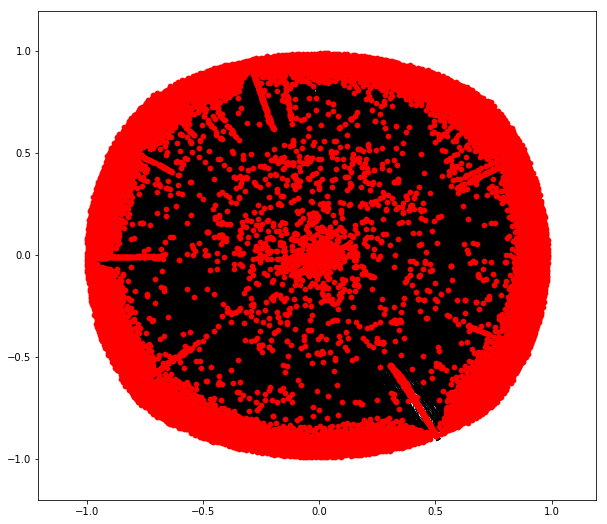

8.007023930549622


In [164]:
start = time.time()
plt.figure(figsize=(10,9))
nx.draw_networkx(nxgraph, with_labels=False, node_size=30, linewidths=0.2)
plt.show()
print((time.time()-start)/60)
# 8.3 Mins

In [ ]:
'''
email addresses need to be cleaned and entries with multiple addresses 
need to be split and cleaned with separate row added for each address (i.e.)
there should be a single address for one to one interaction

Email addresses should be minimized and unwanted addresses should be removed
'''
